In [1]:
import os
import pickle


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from wordcloud import STOPWORDS
import regex as re
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.metrics import confusion_matrix
from sklearn import svm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
path_to_save = '/content/drive/MyDrive/ironAlgo'
os.listdir(path_to_save)

['IronAlgoHomeAsignment_w2v.ipynb', 'haaretzFeb26', 'bibiFeb26']

In [3]:
headline_list_haaretz = pickle.load(open(f'{path_to_save}/haaretzFeb26', 'rb'))
print(len(headline_list_haaretz))

headline_list_bibi = pickle.load(open(f'{path_to_save}/bibiFeb26', 'rb'))
print(len(headline_list_bibi))

360
260


# prepare the headlines for vectorizing - notebook 'scrap_text_preprocess.ipynb' has all detailes, the following functions combine the preprocessing steps

In [4]:
def clean_sentence(sentence):
    return re.sub(r"(@\[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", sentence.lower())

def headline_preparation(headline):
    clean_headline = clean_sentence(headline).replace('netanyahus', 'netanyahu')
    token_headline = word_tokenize(clean_headline)
    
    stopwords = set(STOPWORDS)
    headline_list = [word for word in token_headline if word not in stopwords]
    if len(headline_list)<3:
        return None
    else:
        return headline_list

def list_of_headlines_preparation(list_of_headlines):
  list_of_headlines_prep_None = [headline_preparation(headline) for headline in list_of_headlines]
  list_of_headlines_prep = [headline_list for headline_list in list_of_headlines_prep_None if headline_list!=None]
  return list_of_headlines_prep

In [5]:
headline_list_haaretz_prep = list_of_headlines_preparation(headline_list_haaretz)
headline_list_bibi_prep = list_of_headlines_preparation(headline_list_bibi)

In [6]:
print(f'there is {len(headline_list_haaretz_prep)} Haaretz headlines, and {len(headline_list_bibi_prep)} Israel haYom headlines')

there is 356 Haaretz headlines, and 237 Israel haYom headlines


In [7]:
num_train = 200 #chose number of training samples (equal for both newspapers to create balanced train dataset)

### example of the preprocessing

In [8]:
headline_list_haaretz[0]

'Netanyahu’s Dogmatic Right-hand Man Has Already Blocked Off His Escape Route'

In [9]:
headline_list_haaretz_prep[0]

['netanyahu',
 'dogmatic',
 'righthand',
 'man',
 'already',
 'blocked',
 'escape',
 'route']

# transform each word into vector
## I use Word2vec library, train it on it's standart common_texts and add headlines. I have decided to add each headline separately as well as all headlines combined for each newspaper to link words from a specific newspaper (ussually improves both models)
## note, i am using only train samples to train the word2vec model

In [10]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec


vector_size = 10

text_to_train = common_texts+headline_list_haaretz_prep[:num_train]+headline_list_bibi_prep[:num_train]+\
  [[item for sublist in headline_list_bibi_prep[:num_train] for item in sublist]]+[[item for sublist in headline_list_haaretz_prep[:num_train] for item in sublist]]
model = Word2Vec(sentences=text_to_train, size=vector_size, window=100, min_count=1, workers=4)
# model.save("word2vec.model")

## visualisation of the words

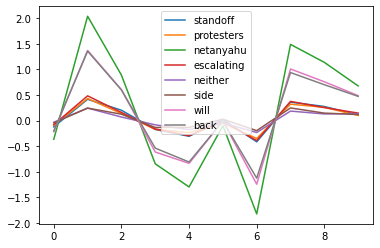

In [11]:
for word in headline_list_haaretz_prep[1]:
  vector = model[word]
  plt.plot(vector, label=word)
plt.legend()
plt.show()

## I want to try two strategies to obtain headline vector representation from word vectors: 
## 1) average of all words

In [12]:
def get_vectors_av(headline_list):
  matrix_all_headlines = np.empty((0, vector_size))
  for headline in headline_list:
    matrix_all_words = np.empty((0, vector_size))
    for word in headline:
      if word in model.wv.vocab.keys():
        vector_word = model[word]
      else:
        continue
      matrix_all_words = np.concatenate((matrix_all_words, vector_word.reshape(1,-1)))
    if matrix_all_words.shape[0] != 0:
      vector_headline = matrix_all_words.mean(0)
    else:
      vector_headline = np.zeros(vector_size)
    matrix_all_headlines = np.concatenate((matrix_all_headlines, vector_headline.reshape(1,-1)))

  return matrix_all_headlines

## 2) first two wods of a haedline concatenated with average of the rest of the words in a headline

In [13]:
def get_vectors_concat(headline_list):
  matrix_all_headlines = np.empty((0, vector_size*3))
  for headline in headline_list:
    matrix_all_words = np.empty((0, vector_size))
    for word in headline:
      if word in model.wv.vocab.keys():
        vector_word = model[word]
      else:
        continue
      matrix_all_words = np.concatenate((matrix_all_words, vector_word.reshape(1,-1)))
    if matrix_all_words.shape[0] == 0:
      vector_headline = np.zeros(vector_size*3)
    elif matrix_all_words.shape[0] == 1:
      vector_headline = np.concatenate((matrix_all_words[0], np.zeros(vector_size*2)))
    elif matrix_all_words.shape[0] == 2:
      vector_headline = np.concatenate((matrix_all_words[0], matrix_all_words[1], np.zeros(vector_size)))
    else:
      vector_headline = np.concatenate((matrix_all_words[0], matrix_all_words[1], matrix_all_words[1:].mean(0)))
    matrix_all_headlines = np.concatenate((matrix_all_headlines, vector_headline.reshape(1,-1)))

  return matrix_all_headlines

## visualisation of the headlines

In [14]:
matrix_all_headlines_haaretz = get_vectors_av(headline_list_haaretz_prep)
matrix_all_headlines_bibi = get_vectors_av(headline_list_bibi_prep)

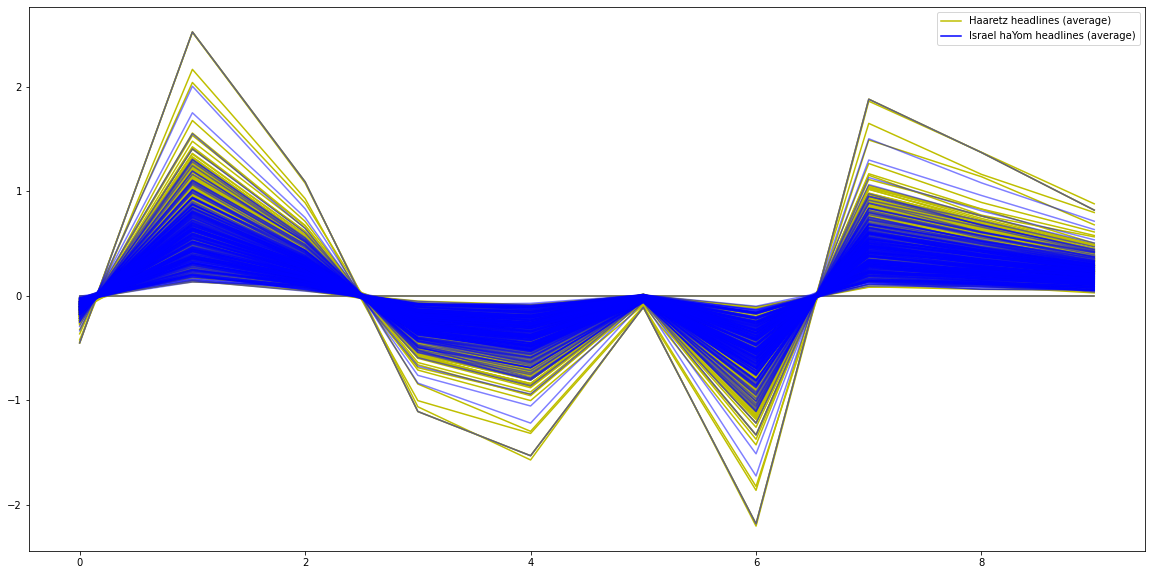

In [15]:
plt.figure(figsize=(20,10))
plt.plot(matrix_all_headlines_haaretz.T, 'y')
plt.plot(matrix_all_headlines_haaretz[0], 'y', label='Haaretz headlines (average)')

plt.plot(matrix_all_headlines_bibi.T, 'b', alpha=0.5)
plt.plot(matrix_all_headlines_bibi[0], 'b', label='Israel haYom headlines (average)')
plt.legend()
plt.show()

# function to create train and test sets. It has two choices:
## 1) weather to include number of words in a headline as an additional feature
## 2) how to combine words' vectors into headline - average or concatenation (of 2 first words and average of rest of the words)

In [16]:
def get_train_test(headline_list_haaretz_prep, headline_list_bibi_prep, num_train, \
                   with_counts=True, w2v_strat='average'):


  y_train = np.array([0]*num_train+[1]*num_train)
  y_test = np.array([0]*(len(headline_list_haaretz_prep)-num_train)+[1]*(len(headline_list_bibi_prep)-num_train))

  if w2v_strat=='average':

    matrix_all_headlines_haaretz = get_vectors_av(headline_list_haaretz_prep)
    matrix_all_headlines_bibi = get_vectors_av(headline_list_bibi_prep)
    X_train = np.concatenate((matrix_all_headlines_haaretz[:num_train], matrix_all_headlines_bibi[:num_train]))
    X_test = np.concatenate((matrix_all_headlines_haaretz[num_train:], matrix_all_headlines_bibi[num_train:]))

  if w2v_strat=='concat':
    matrix_all_headlines_haaretz = get_vectors_concat(headline_list_haaretz_prep)
    matrix_all_headlines_bibi = get_vectors_concat(headline_list_bibi_prep)
    X_train = np.concatenate((matrix_all_headlines_haaretz[:num_train], matrix_all_headlines_bibi[:num_train]))
    X_test = np.concatenate((matrix_all_headlines_haaretz[num_train:], matrix_all_headlines_bibi[num_train:]))

  if with_counts:
    num_words_haaretz = np.array([len(headline) for headline in headline_list_haaretz_prep])
    num_words_bibi = np.array([len(headline) for headline in headline_list_bibi_prep])

    num_words_train = np.concatenate((num_words_haaretz[:num_train], num_words_bibi[:num_train]))
    num_words_test = np.concatenate((num_words_haaretz[num_train:], num_words_bibi[num_train:]))
    X_train = np.concatenate((X_train, num_words_train.reshape(-1,1)), 1)
    X_test = np.concatenate((X_test, num_words_test.reshape(-1,1)), 1)

  np.random.seed(29)
  arr = np.arange(num_train*2)
  np.random.shuffle(arr)
  return X_train[arr], y_train[arr], X_test, y_test

# build models - XGBoost and SVM, parameters are chosen by the best CV score (5 folds)

In [17]:
def CV_results(grid):
    dict_results = grid.cv_results_
    CV_test = round(dict_results['mean_test_score'].max()*100, 1)
    idx = dict_results['mean_test_score'].argmax()
    param_dict = dict_results['params'][idx]
    return CV_test, param_dict

In [18]:
def get_performance(X, y, model):
  print('Test performance: ')
  C = confusion_matrix(y, model.predict(X))
  sens_haaretz = C[0,0]/C.sum(1)[0]
  sens_bibi = C[1,1]/C.sum(1)[1]
  # accuracy = (C[0,0]+C[1,1])/C.sum()
  print(f'sensitivity of Haaretz = {round(sens_haaretz*100, 1)}')
  print(f'sensitivity of Israel haYom = {round(sens_bibi*100, 1)}')
  print(f'balanced accuacy = {round((sens_haaretz+sens_bibi)*50, 1)}')
  # return sens_haaretz, sens_bibi, accuracy
  return None

In [19]:
def train_xgboost(X_train, y_tain):
  gbc_estimator = gbc(random_state=21)
  params = {'n_estimators': range(10, 31), 'learning_rate':[0.01, 0.05, 0.1, 0.5]}
  grid = GridSearchCV(estimator=gbc_estimator, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')
  grid.fit(X_train, y_train)

  cv_test, param_dict = CV_results(grid)
  print(param_dict)
  print(f'maximum CV accuracy = {cv_test}')
  gbc_model = gbc(random_state=21, n_estimators=param_dict['n_estimators'], learning_rate=param_dict['learning_rate'])
  gbc_model.fit(X_train, y_train)
  return gbc_model

In [20]:
def train_SVM(X_train, y_train):
  clf_estimator = svm.SVC(kernel='rbf')
  params ={'gamma': list(np.linspace(0.1, 2, 20)) + ['scale', 'auto'],
                    'C': [0.1, 1, 10]}
  grid = GridSearchCV(estimator=clf_estimator, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')
  grid.fit(X_train, y_train)

  cv_test, param_dict = CV_results(grid)
  print(param_dict)
  print(f'maximum test CV accuracy = {cv_test}')
  svm_model = svm.SVC(kernel='rbf', gamma=param_dict['gamma'], C=param_dict['C'])
  svm_model.fit(X_train, y_train)
  return svm_model

# So, I am building two models - SVM and XGBoost and using different features to chose the winning strategy

In [21]:
for counts in [True, False]:
  for strategy in ['average', 'concat']:
    print(f'\n\nUse word counts: {counts}, sentence vectorization: {strategy} of word vectors')
    X_train, y_train, X_test, y_test = get_train_test(headline_list_haaretz_prep, headline_list_bibi_prep, num_train, \
                      with_counts=counts, w2v_strat=strategy)
    print('\nXGboost model')
    gbc_model = train_xgboost(X_train, y_train)
    get_performance(X_test, y_test, gbc_model)
    print('\nSVM model')    
    svm_model = train_SVM(X_train, y_train)
    get_performance(X_test, y_test, svm_model)



Use word counts: True, sentence vectorization: average of word vectors

XGboost model
{'learning_rate': 0.05, 'n_estimators': 25}
maximum CV accuracy = 63.3
Test performance: 
sensitivity of Haaretz = 70.5
sensitivity of Israel haYom = 62.2
balanced accuacy = 66.3

SVM model
{'C': 1, 'gamma': 0.5}
maximum test CV accuracy = 66.0
Test performance: 
sensitivity of Haaretz = 73.1
sensitivity of Israel haYom = 56.8
balanced accuacy = 64.9


Use word counts: True, sentence vectorization: concat of word vectors

XGboost model
{'learning_rate': 0.5, 'n_estimators': 24}
maximum CV accuracy = 66.5
Test performance: 
sensitivity of Haaretz = 72.4
sensitivity of Israel haYom = 48.6
balanced accuacy = 60.5

SVM model
{'C': 10, 'gamma': 'auto'}
maximum test CV accuracy = 64.0
Test performance: 
sensitivity of Haaretz = 59.6
sensitivity of Israel haYom = 70.3
balanced accuacy = 64.9


Use word counts: False, sentence vectorization: average of word vectors

XGboost model
{'learning_rate': 0.05, 'n_

# the best choice would be to use aditional feature - lenght of a headline, and average word vectors to obtain headline, the winning model in terms of CV score and test scores:
## XGboost model {'learning_rate': 0.05, 'n_estimators': 25, 'random_state': 21}
maximum CV accuracy = 63.3
Test performance: 
sensitivity of Haaretz = 70.5
sensitivity of Israel haYom = 62.2
balanced accuacy = 66.3
